## Visualize Metrics: Spectrograms & Historgrams

In [6]:
import scipy
import scipy.signal
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import torch
sys.path.append("../")
sys.path.append("../data")
sys.path.append("../visualize")
sys.path.append("../data/")
sys.path.append("../artifacts/")
from load_EEGs_mc import EEGDatasetMc
from data_utils_siyi import computeTimeFreqRep
import stacklineplot
from constants import *
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [12, 7]

### Load Data

In [29]:
filename = "../results/sample_800.npy"
sample_generated = np.load(filename)

In [3]:
files_csv = "../data/dataset_csv/sample_file.csv"
dataset = EEGDatasetMc(files_csv, select_channels=list(range(4)), max_num_examples=1000, length=784)

In [4]:
sample_real = dataset[9]
sample_real = sample_real.numpy()

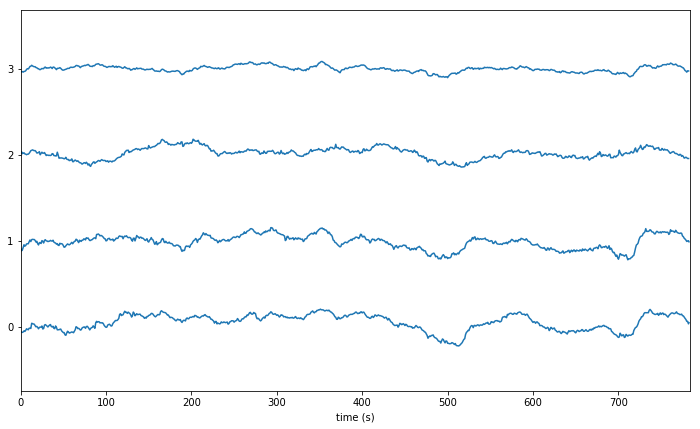

In [7]:
stacklineplot.stackplot(sample_real, yscale=.3)

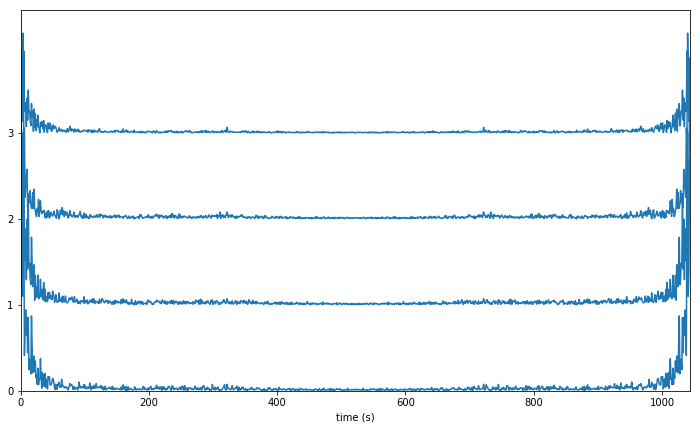

In [8]:
stacklineplot.stackplot(computeTimeFreqRep(sample_real), yscale=3)

In [31]:
sample_generated.shape

(16, 784)

In [59]:
from operator import add
import pandas as pd

def get_bands_batch(batch):
    sum_bands = [0] * 5
    for example in batch:
        sum_bands = list( map(add, sum_bands, get_bands(example)) )
    
    avg_bands = [x / len(batch) for x in sum_bands]
    return avg_bands
    
    
        
def get_bands(data):
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    return list(eeg_band_fft.values())

def graph_bands(bands_list):
    eeg_bands = {
        'Delta': bands_list[0],
        'Theta': bands_list[1],
        'Alpha': bands_list[2],
        'Beta': bands_list[3],
        'Gamma': bands_list[4]
    }
    
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")

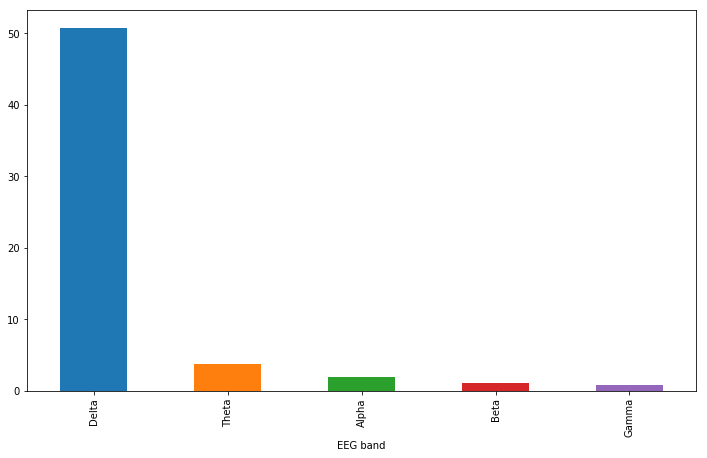

In [63]:
bands = get_bands_batch(sample_generated)
graph_bands(bands)

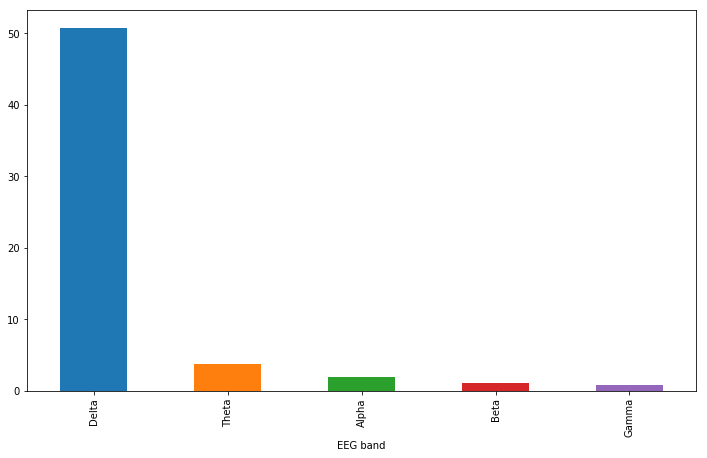

In [64]:
bands = get_bands_batch(sample_real)
graph_bands(bands)

{'Delta': 50.688553, 'Theta': 3.6770577, 'Alpha': 1.9297272, 'Beta': 1.0770618, 'Gamma': 0.71647286}


Text(0.5, 0, 'EEG band')

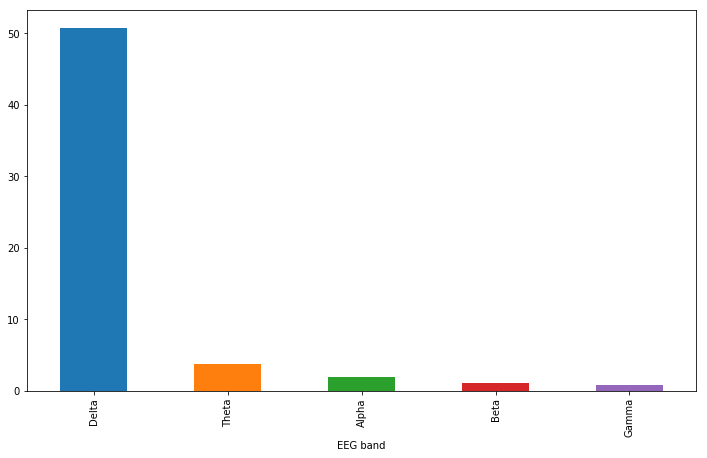

In [56]:
# https://dsp.stackexchange.com/questions/45345/how-to-correctly-compute-the-eeg-frequency-bands-with-python
import numpy as np
fs = 200                                # Sampling rate (512 Hz)
# data = np.random.uniform(0, 100, 1024)  # 2 sec of data b/w 0.0-100.0
# data = sample_real[4:5]
data = sample_generated[4]

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
print(eeg_band_fft)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")

In [9]:
def get_samples_real_stack(dataset, n=-1):
    # reutns all examples of dataset in a singe batch
    if n == -1 or n > len(dataset):
        n = len(dataset)
    out = np.zeros(dataset[0].shape)
        
    for i in range(n):
        out = np.vstack((out, dataset[i].numpy()))
    out = out[1:, :]
    return out
    

In [10]:
sample_real = get_samples_real_stack(dataset)

In [17]:
spectrogram(sample_real[:1], 200)

ValueError: negative dimensions are not allowed

In [13]:
sample_real.shape

(4003, 784)

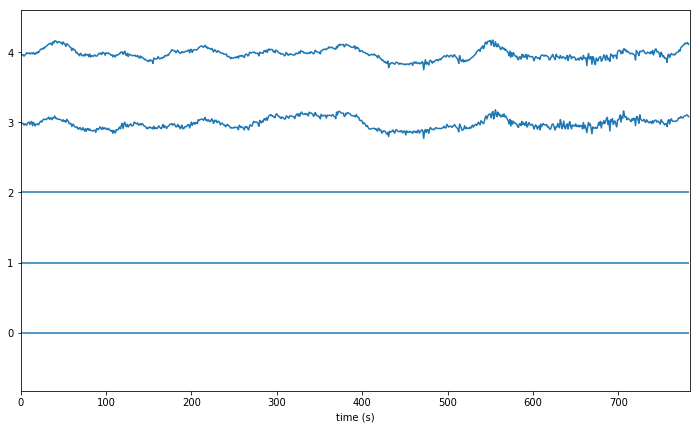

In [21]:
stacklineplot.stackplot(sample_real[:5], yscale=.3)

### Spectrograms

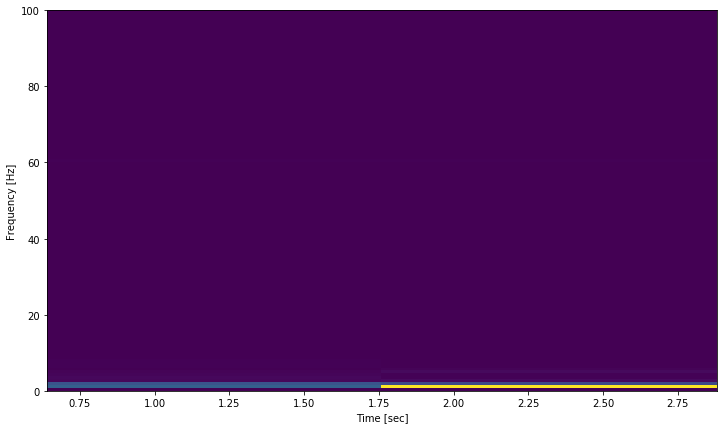

In [19]:
# Spectrogram of a Single Generated Recording
f, t, Sxx = scipy.signal.spectrogram(sample_generated[1], 200)
Sxx = Sxx / np.linalg.norm(Sxx)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [655]:
def compute_spectrogram(signals, fs=200, graph=False):
    window = ('tukey', .25) # turkey is the default
#     window = scipy.signal.triang(60)
    f, t, Sxx = scipy.signal.spectrogram(signals, fs, window=window)
#     Sxx = Sxx / np.linalg.norm(Sxx)
    if graph:
        plt.pcolormesh(t, f, Sxx)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    return  f, t, np.squeeze(Sxx)

In [540]:
def compute_average_spectrogram(signals, fs=200, graph=False):
    
    f, t, total_spectrogram = compute_spectrogram(signals)
    total_spectrogram = np.sum(total_spectrogram, axis=0)
    
    if graph:
        plt.pcolormesh(t, f, total_spectrogram)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    total_spectrogram = np.sum(total_spectrogram, axis=1)
    total_spectrogram /= signals.shape[0]
    
    return total_spectrogram
        

Real Samples AVG

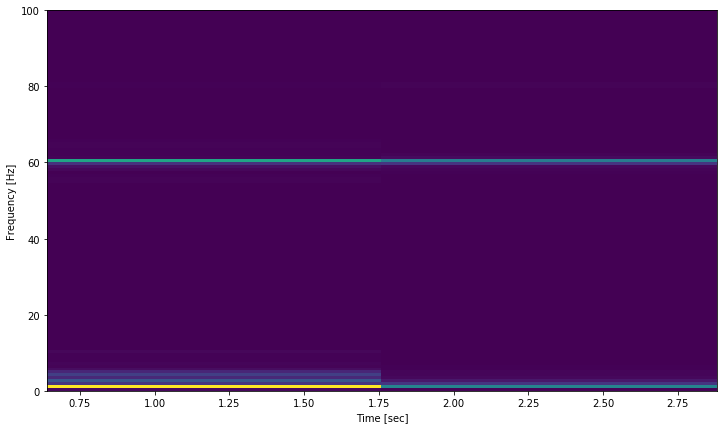

(129,)

In [541]:
compute_average_spectrogram(sample_real, graph=True).shape

Generated Samples AVG

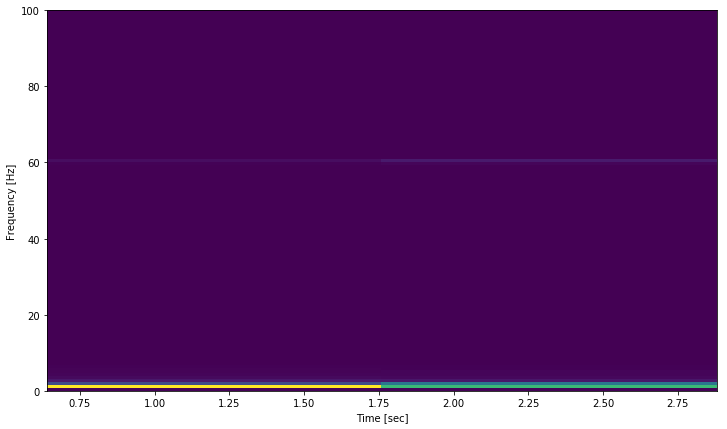

(129,)

In [542]:
compute_average_spectrogram(sample_generated, graph=True).shape

In [656]:
def get_signal_diff_spectrogram(signals_a, signals_b):
    m_singals_a = signals_a.shape[0]
    m_singals_b = signals_b.shape[0]
    assert(signals_a.shape[1] == signals_b.shape[1]), "signals should be equal length"
    combined = np.vstack((signals_a, signals_b))
    _, _, combined_spectrogram = compute_spectrogram(combined)
    
    combined_spectrogram = np.sum(combined_spectrogram, axis=2)
    
    spectrogram_a = combined_spectrogram[:m_singals_a]
    spectrogram_b = combined_spectrogram[m_singals_a:]
    
    # Reduce dimension again b/c time dim isn't relevant - just want total amount of freq
    spectrogram_a = np.sum(spectrogram_a, axis=0)
    spectrogram_a = spectrogram_a / np.linalg.norm(spectrogram_a)
    
    spectrogram_b = np.sum(spectrogram_b, axis=0)
    spectrogram_b = spectrogram_a / np.linalg.norm(spectrogram_b)
    
    return np.sum(np.abs(spectrogram_a - spectrogram_b)) #/ (m_singals_a + m_singals_b) * .4e3

In [632]:
print("Should be near 0:", get_signal_diff_spectrogram(sample_real[:2000], sample_real[2000:]))
print("Should be higher:", get_signal_diff(sample_real[:100], sample_generated[:100]))

Should be near 0: 659.6066474914551
Should be higher: 0.23937618732452393


### Historgrams

Generated EEGs

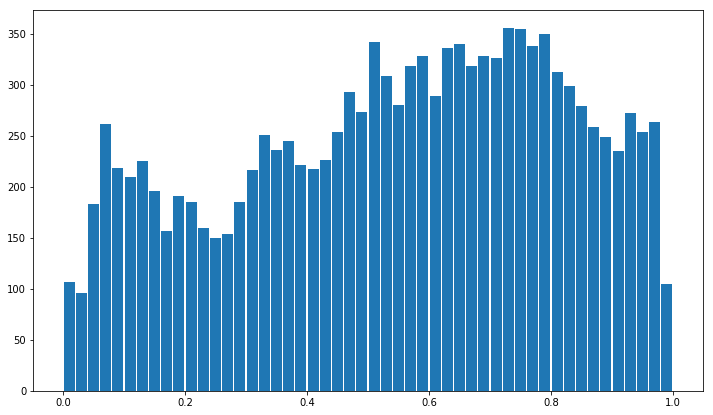

In [549]:
sample = sample_generated
sample_flattened = sample.reshape(-1)
hist, bins = np.histogram(sample_flattened, range=(0,1), bins=50)
width = .9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

Real EEGs

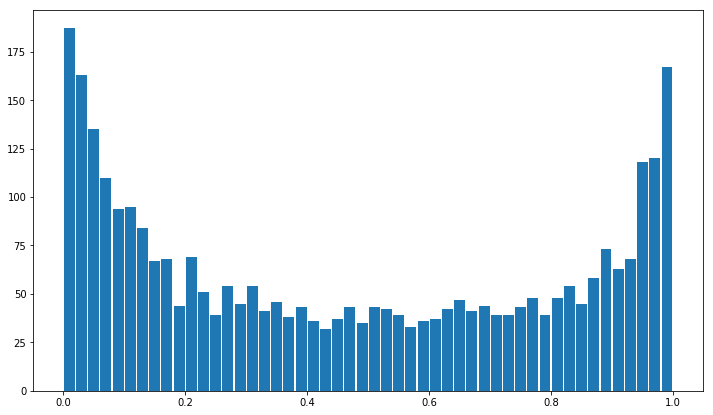

In [550]:
sample = sample_real
sample_flattened = sample.reshape(-1)
hist, bins = np.histogram(sample_flattened, range=(0,1), bins=50)
width = .9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


In [715]:
def get_signal_diff_histogram(signals_a, signals_b, n_bins=50):
    signals_a = signals_a.reshape(-1)
    signals_b = signals_b.reshape(-1)
    hist_a, _ = np.histogram(signals_a, bins=n_bins)
    hist_b, _ = np.histogram(signals_b, bins=n_bins)
    
    hist_a = hist_a / np.linalg.norm(hist_a)
    hist_b = hist_b / np.linalg.norm(hist_b)
    
    return np.sum(np.abs(hist_a - hist_b)) #/ (signals_a.shape[0] + signals_b.shape[0])# * 5e-6
    

In [620]:
print("Should be near 0:", get_signal_diff_histogram(sample_real[:2000], sample_real[2000:]))
print("Should be higher", get_signal_diff_histogram(sample_real[:100], sample_generated[:100]))

Should be near 0: 0.015680000000000003
Should be higher 0.04848


In [707]:
def get_metrics(model_filename, dataset, z_dim, n_dataset=2000, n_model=2000):
    # works for mc or single channel
    
    # compute samples with loaded model
    model = torch.load(model_filename)
    sample_generated = torch.randn(n_model, 1, z_dim).cuda()
    sample_generated = model.decode(sample_generated).cpu().detach().numpy()
    sample_generated = sample_generated.reshape(-1, sample_generated.shape[-1])
    
    # grab n exmples from dataset
    dataset = [x.numpy() for x in dataset]
    random.shuffle(dataset)
    sample_real = np.asarray(dataset[:n_dataset])
    sample_real = sample_real.reshape(-1, sample_real.shape[-1])
#     sample_real = get_samples_real_stack(dataset, n=n_dataset)
#     sample_real = sample_real.reshape(-1, sample_real.shape[-1])
    
    assert(sample_real.shape[-1] == sample_generated.shape[-1]), "Signal length should be the same"
    
    
    hist_diff = get_signal_diff_histogram(sample_real, sample_generated)
    spec_diff = get_signal_diff_spectrogram(sample_real, sample_generated)
    print("HIST DIFF", hist_diff)
    print("SPEC DIFF", spec_diff)
    return hist_diff, spec_diff

In [723]:
# model_filename = "../reconstruction/saved_models/1a"
model_filename = "../reconstruction/saved_models/1a_conv_mc"
dataset = dataset
# z_dim = 20
z_dim = 32
get_metrics(model_filename, dataset, z_dim, n_dataset=100, n_model=100)

HIST DIFF 5.281070651839649
SPEC DIFF 2.3437297


(5.281070651839649, 2.3437297)

In [719]:
get_metrics(model_filename, dataset, z_dim, n_dataset=10000, n_model=10000)

HIST DIFF 5.042720332959494
SPEC DIFF 2.611217


(5.042720332959494, 2.611217)

In [ ]:
class Metrics():
    def __init__(self, dataset):
        self.dataset = dataset
        
    def gen_baseline_histogram(self):
        pass
    
    def gen_baseline_fft(self):
        pass
    
    

In [747]:
sample_real.shape

(4, 784)

In [821]:
def get_recon_diff_fft(x, recon_x):
    fft_x = np.fft.fft(x)
    fft_recon_x = np.fft.fft(recon_x)

    fft_x /= np.sum(fft_x)
    fft_recon_x /= np.sum(fft_recon_x)
    
    return (np.sum(abs(fft_x - fft_recon_x)))


In [818]:
def get_recon_diff_hist(x, recon_x, n_bins=50):
    signals_a = x.reshape(-1)
    signals_b = recon_x.reshape(-1)
    hist_a, _ = np.histogram(signals_a, bins=n_bins)
    hist_b, _ = np.histogram(signals_b, bins=n_bins)
    
    hist_a = hist_a / np.linalg.norm(hist_a)
    hist_b = hist_b / np.linalg.norm(hist_b)
    
    return np.sum(np.abs(hist_a - hist_b))

In [819]:
def get_recon_metrics(x, recon_x):
    fft_diff = get_recon_diff_fft(x, recon_x)
    hist_diff = get_recon_diff_hist(x, recon_x)
    return fft_diff, hist_diff

In [826]:
get_recon_metrics(sample_real[1], sample_real[0])
# print(get_recon_diff_fft(sample_real[:2], sample_real[2:]))
# print(get_recon_diff_hist(sample_real[:2], sample_real[2:]))

(46.321865, 2.078782456412182)